# Federated 2d XRay registration with MONAI

## Introduction

This tutorial shows how to deploy in Fed-BioMed the 2d image classification example provided in the project MONAI (https://monai.io/):

https://github.com/Project-MONAI/tutorials/blob/master/2d_registration/registration_mednist.ipynb

Being MONAI based on PyTorch, the deployment within Fed-BioMed follows seamlessy the same general structure of general PyTorch models. 

Following the MONAI example, this tutorial is based on the MedNIST dataset:

https://github.com/Project-MONAI/MONAI/blob/master/examples/notebooks/mednist_tutorial.ipynb.

## Creating MedNIST nodes

MedNIST provides an artificial 2d classification dataset created by gathering different medical imaging datasets from TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset. The dataset is kindly made available by Dr. Bradley J. Erickson M.D., Ph.D. (Department of Radiology, Mayo Clinic) under the Creative Commons CC BY-SA 4.0 license.

To proceed with the tutorial, we created an iid partitioning of the MedNIST dataset between 3 clients. Each client has 3000 image samples for each class. The training partitions are availables at the following link:

https://drive.google.com/file/d/1vLIcBdtdAhh6K-vrgCFy_0Y55dxOWZwf/view

The dataset owned by each client has structure:


└── client_*/

    ├── AbdomenCT/
    
    └── BreastMRI/
    
    └── CXR/
    
    └── ChestCT/
    
    └── Hand/
    
    └── HeadCT/      

To create the federated dataset, we follow the standard procedure for node creation/population of Fed-BioMed. 
After activating the fedbiomed network with the commands

`source ./scripts/fedbiomed_environment network`

and 

`./scripts/fedbiomed_run network`

we create a first node by using the commands

`source ./scripts/fedbiomed_environment node`

`./scripts/fedbiomed_run node start`

We then poulate the node with the data of first client:

`./scripts/fedbiomed_run node add`

We select option 3 (images) to add MedNIST partition of client 1, by just picking the folder of client 1. We use `mednist` as tag to save the selected dataset.
We can further check that the data has been added by executing `./scripts/fedbiomed_run node list`

Following the same procedure, we create the other two nodes with the datasets of client 2 and client 3 respectively.


## Running Fed-BioMed Researcher

We are now ready to start the reseracher enviroment with the command `source ./scripts/fedbiomed_environment researcher`, and open the Jupyter notebook with `./scripts/fedbiomed_run researcher`. 

We can first quesry the network for the mednist dataset. In this case, the nodes are sharing the respective partitions unsing the same tag `mednist`:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fedbiomed.researcher.requests import Requests
req = Requests()
req.list(verbose=True)

2022-01-04 16:51:19,758 fedbiomed INFO - Component environment:
2022-01-04 16:51:19,759 fedbiomed INFO - - type = ComponentType.RESEARCHER
2022-01-04 16:51:21,022 fedbiomed INFO - Messaging researcher_6614eef6-5331-401a-b4de-4e2a69e51c81 successfully connected to the message broker, object = <fedbiomed.common.messaging.Messaging object at 0x1086d1790>
2022-01-04 16:51:21,046 fedbiomed INFO - Listing available datasets in all nodes... 
2022-01-04 16:51:21,054 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / DEBUG - Message received: {'researcher_id': 'researcher_6614eef6-5331-401a-b4de-4e2a69e51c81', 'command': 'list'}
2022-01-04 16:51:21,054 fedbiomed INFO - log from: node_d562b808-8ed3-401b-8222-494283894e5d / DEBUG - Message received: {'researcher_id': 'researcher_6614eef6-5331-401a-b4de-4e2a69e51c81', 'command': 'list'}
2022-01-04 16:51:21,057 fedbiomed INFO - log from: node_de591a20-68ff-4697-8abb-9daccd955df2 / DEBUG - Message received: {'researcher_id': 'res

{'node_b4095fb0-5dac-49f5-9af7-a478f8942a4a': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': 'bla',
   'shape': [18000, 3, 64, 64]}],
 'node_d562b808-8ed3-401b-8222-494283894e5d': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': 'bla',
   'shape': [16954, 3, 64, 64]}],
 'node_de591a20-68ff-4697-8abb-9daccd955df2': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': 'bla',
   'shape': [18000, 3, 64, 64]}]}

## Create an experiment to train a model on the data found

The code for network and data loader of the MONAI tutorial can now be deployed in Fed-BioMed.
We first import the necessary modules from `fedbiomed` and `monai` libraries:

In [3]:
from fedbiomed.researcher.environ import environ
import tempfile
tmp_dir_model = tempfile.TemporaryDirectory(dir=environ['TMP_DIR']+'/')
model_file = tmp_dir_model.name + '/class_export_mednist.py'

In [4]:
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset

We can now define the training plan. Note that we use the standard `TorchTrainingPlan` natively provided in Fed-BioMed. We reuse the `MedNISTDataset` data loader defined in the original MONAI tutorial, which is returned by the method `training_data`, which also implements the data parsing from the nodes `dataset_path`. We should also properly define the `training_routine`, following the MONAI tutorial. According to the MONAI tutorial, the model is the `GlobalNet` and the loss is `MSELoss`.

In [5]:
%%writefile "$model_file"

import os
import numpy as np
import torch
from torch.nn import MSELoss
import torch.nn as nn
from fedbiomed.common.torchnn import TorchTrainingPlan
from fedbiomed.common.logger import logger
from torchvision import datasets, transforms
from typing import Union, List

from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset

# Here we define the model to be used. 
class MyMonaiTrainingPlan(TorchTrainingPlan):
    def __init__(self):
        super(MyMonaiTrainingPlan, self).__init__()
        
        # Here we define the custom dependencies that will be needed by our custom Dataloader
        # In this case, we need the torch DataLoader classes
        # Since we will train on MNIST, we need datasets and transform from torchvision
        deps = ["import numpy as np",
                "import os",
                "from fedbiomed.common.logger import logger",
                "from torch.nn import MSELoss",
                "from typing import Union, List",
                "from monai.utils import set_determinism, first",
                "from monai.transforms import (EnsureChannelFirstD,Compose,LoadImageD,RandRotateD,RandZoomD,ScaleIntensityRanged,EnsureTypeD,)",
                "from monai.data import DataLoader, Dataset, CacheDataset",
                "from monai.config import print_config, USE_COMPILED",
                "from monai.networks.nets import GlobalNet",
                "from monai.networks.blocks import Warp",
                "from monai.apps import MedNISTDataset",]
        self.add_dependency(deps)
        
        use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda:0" if use_cuda else "cpu")
        
        self.model = GlobalNet(
            image_size=(64, 64),
            spatial_dims=2,
            in_channels=2,  # moving and fixed
            num_channel_initial=16,
            depth=3)#.to(self.device)
        self.image_loss = MSELoss()
        
        if USE_COMPILED:
            self.warp_layer = Warp(3, "border").to(self.device)
        else:
            self.warp_layer = Warp("bilinear", "border").to(self.device)
            
        self.optimizer = torch.optim.Adam(self.model.parameters(), 1e-5)
        
    def training_data(self, batch_size = 20):
        # Custom torch Dataloader for MedNIST data
        data_path = self.dataset_path
        # The following line is needed if client structure does not contain the "/MedNIST" folder
        MedNISTDataset.dataset_folder_name = ""
        train_data = MedNISTDataset(root_dir=data_path, section="training", download=False, transform=None)
        training_datadict = [
            {"fixed_hand": item["image"], "moving_hand": item["image"]}
            for item in train_data.data if item["label"] == 4  # label 4 is for xray hands
        ]
        train_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
        train_ds = CacheDataset(data=training_datadict[:1000], transform=train_transforms,
                                cache_rate=1.0, num_workers=0)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
        
        return train_loader

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, moving, fixed):
        ddf = self.forward(torch.cat((moving, fixed), dim=1))
        pred_image = self.warp_layer(moving, ddf)
        loss = self.image_loss(pred_image, fixed)
        return loss
    
    def training_routine(self,
                         epochs: int = 2,
                         log_interval: int = 10,
                         lr: Union[int, float] = 1e-3,
                         batch_size: int = 48,
                         batch_maxnum: int = 0,
                         dry_run: bool = False,
                         monitor=None):
        
        if self.optimizer is None:
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

        self.model.to(self.device)
        
        training_data = self.training_data(batch_size=batch_size)

        for epoch in range(1, epochs + 1):
            self.model.train()
            for batch_idx, batch_data in enumerate(training_data):
                self.optimizer.zero_grad()
                moving = batch_data["moving_hand"].to(self.device)
                fixed = batch_data["fixed_hand"].to(self.device)
                res = self.training_step(moving, fixed)
                res.backward()
                self.optimizer.step()

                # do not take into account more than batch_maxnum
                # batches from the dataset
                if (batch_maxnum > 0) and (batch_idx >= batch_maxnum):
                    logger.debug('Reached {} batches for this epoch, ignore remaining data'.format(batch_maxnum))
                    break

                if batch_idx % log_interval == 0:
                    logger.info('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch,
                        batch_idx * len(moving),
                        len(training_data.dataset),
                        100 * batch_idx / len(training_data),
                        res.item()))

                    # Send scalar values via general/feedback topic
                    if monitor is not None:
                        monitor.add_scalar('Loss', res.item(), batch_idx, epoch)

                    if dry_run:
                        return

Writing /Users/mlorenzi/works/temp/fedbiomed/var/tmp/tmpfy88o79h/class_export_mednist.py


We now set the model and training parameters. Note that in this case, no model argument is required.

In [6]:
model_args = {}

training_args = {
    'batch_size': 16, 
    'lr': 1e-5, 
    'epochs': 3, 
    'dry_run': False,  
    'batch_maxnum':250 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

The experiment can be now defined, by providing the `mednist` tag, and running the local training on nodes with model defined in `model_path`, standard `aggregator` (FedAvg) and `client_selection_strategy` (all nodes used). Federated learning is going to be perfomed through 5 optimization rounds.

In [7]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

tags =  ['mednist']
rounds = 5

exp = Experiment(tags=tags,
                 #clients=None,
                 model_path=model_file,
                 model_args=model_args,
                 model_class='MyMonaiTrainingPlan',
                 training_args=training_args,
                 rounds=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-01-04 16:51:33,296 fedbiomed INFO - Searching dataset with data tags: ['mednist'] for all nodes
2022-01-04 16:51:33,303 fedbiomed INFO - log from: node_de591a20-68ff-4697-8abb-9daccd955df2 / DEBUG - Message received: {'researcher_id': 'researcher_6614eef6-5331-401a-b4de-4e2a69e51c81', 'tags': ['mednist'], 'command': 'search'}
2022-01-04 16:51:33,305 fedbiomed INFO - log from: node_d562b808-8ed3-401b-8222-494283894e5d / DEBUG - Message received: {'researcher_id': 'researcher_6614eef6-5331-401a-b4de-4e2a69e51c81', 'tags': ['mednist'], 'command': 'search'}
2022-01-04 16:51:33,306 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / DEBUG - Message received: {'researcher_id': 'researcher_6614eef6-5331-401a-b4de-4e2a69e51c81', 'tags': ['mednist'], 'command': 'search'}
2022-01-04 16:51:43,308 fedbiomed INFO - Node selected for training -> node_de591a20-68ff-4697-8abb-9daccd955df2
2022-01-04 16:51:43,309 fedbiomed INFO - Node selected for training -> node_d562b808-8ed3-

Let's start the experiment.

By default, this function doesn't stop until all the `rounds` are done for all the clients

In [8]:
exp.run()

2022-01-04 16:51:43,605 fedbiomed INFO - Sampled nodes in round 0 ['node_de591a20-68ff-4697-8abb-9daccd955df2', 'node_d562b808-8ed3-401b-8222-494283894e5d', 'node_b4095fb0-5dac-49f5-9af7-a478f8942a4a']
2022-01-04 16:51:43,606 fedbiomed INFO - Send message to node node_de591a20-68ff-4697-8abb-9daccd955df2 - {'researcher_id': 'researcher_6614eef6-5331-401a-b4de-4e2a69e51c81', 'job_id': '2b86d4d8-14b6-488d-9029-ff7786265fcc', 'training_args': {'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'model_args': {}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/01/04/my_model_e7a6f66e-7295-4e07-82f5-c85a4a7c6822.py', 'params_url': 'http://localhost:8844/media/uploads/2022/01/04/my_model_dfa9eaac-e47e-4221-9549-52af44f6876b.pt', 'model_class': 'MyMonaiTrainingPlan', 'training_data': {'node_de591a20-68ff-4697-8abb-9daccd955df2': ['dataset_e7cd0f44-0504-4bd3-b10d-ae41a7cc708c']}}
2022-01-04 16:51:43,607 fedbiomed DEBUG - researcher_661

2022-01-04 16:51:43,801 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / DEBUG - Dataset_path/Users/mlorenzi/works/temp/MedNIST/client_2
2022-01-04 16:51:45,069 fedbiomed INFO - log from: node_d562b808-8ed3-401b-8222-494283894e5d / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.090961
2022-01-04 16:51:45,085 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.091303
2022-01-04 16:51:45,087 fedbiomed INFO - log from: node_de591a20-68ff-4697-8abb-9daccd955df2 / INFO - Train Epoch: 1 [0/1000 (0%)]	Loss: 0.091012
2022-01-04 16:51:47,607 fedbiomed INFO - log from: node_de591a20-68ff-4697-8abb-9daccd955df2 / INFO - Train Epoch: 1 [160/1000 (16%)]	Loss: 0.073120
2022-01-04 16:51:47,618 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / INFO - Train Epoch: 1 [160/1000 (16%)]	Loss: 0.073862
2022-01-04 16:51:47,619 fedbiomed INFO - log from: node_d562b808-8ed3-401b-8222-494283894e5d / INFO - Tra

2022-01-04 16:52:28,967 fedbiomed INFO - log from: node_d562b808-8ed3-401b-8222-494283894e5d / INFO - Train Epoch: 3 [640/1000 (63%)]	Loss: 0.047443
2022-01-04 16:52:28,990 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / INFO - Train Epoch: 3 [640/1000 (63%)]	Loss: 0.039439
2022-01-04 16:52:31,784 fedbiomed INFO - log from: node_de591a20-68ff-4697-8abb-9daccd955df2 / INFO - Train Epoch: 3 [800/1000 (79%)]	Loss: 0.039115
2022-01-04 16:52:31,793 fedbiomed INFO - log from: node_d562b808-8ed3-401b-8222-494283894e5d / INFO - Train Epoch: 3 [800/1000 (79%)]	Loss: 0.052192
2022-01-04 16:52:31,820 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / INFO - Train Epoch: 3 [800/1000 (79%)]	Loss: 0.045620
2022-01-04 16:52:34,581 fedbiomed INFO - log from: node_de591a20-68ff-4697-8abb-9daccd955df2 / INFO - Train Epoch: 3 [960/1000 (95%)]	Loss: 0.051626
2022-01-04 16:52:34,589 fedbiomed INFO - log from: node_d562b808-8ed3-401b-8222-494283894e5d / INFO - Trai

2022-01-04 16:52:44,057 fedbiomed INFO - log from: node_d562b808-8ed3-401b-8222-494283894e5d / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_6614eef6-5331-401a-b4de-4e2a69e51c81', 'job_id': '2b86d4d8-14b6-488d-9029-ff7786265fcc', 'params_url': 'http://localhost:8844/media/uploads/2022/01/04/researcher_params_f4c46340-70a5-4c3a-8113-7a22ff917a67.pt', 'training_args': {'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training_data': {'node_d562b808-8ed3-401b-8222-494283894e5d': ['dataset_f2c80a1e-24d7-4c88-977f-ceff1acc9009']}, 'model_args': {}, 'model_url': 'http://localhost:8844/media/uploads/2022/01/04/my_model_e7a6f66e-7295-4e07-82f5-c85a4a7c6822.py', 'model_class': 'MyMonaiTrainingPlan', 'command': 'train'}
2022-01-04 16:52:44,058 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_6614eef6-5331-401a-b4de-4e2a69e51c81', 'job_id': '2b86d4d8-14b6-488d-9029-ff77862

2022-01-04 16:53:15,559 fedbiomed INFO - log from: node_de591a20-68ff-4697-8abb-9daccd955df2 / INFO - Train Epoch: 2 [800/1000 (79%)]	Loss: 0.049096
2022-01-04 16:53:15,607 fedbiomed INFO - log from: node_d562b808-8ed3-401b-8222-494283894e5d / INFO - Train Epoch: 2 [800/1000 (79%)]	Loss: 0.031498
2022-01-04 16:53:18,312 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / INFO - Train Epoch: 2 [960/1000 (95%)]	Loss: 0.046636
2022-01-04 16:53:18,336 fedbiomed INFO - log from: node_de591a20-68ff-4697-8abb-9daccd955df2 / INFO - Train Epoch: 2 [960/1000 (95%)]	Loss: 0.043030
2022-01-04 16:53:18,353 fedbiomed INFO - log from: node_d562b808-8ed3-401b-8222-494283894e5d / INFO - Train Epoch: 2 [960/1000 (95%)]	Loss: 0.049909
2022-01-04 16:53:19,003 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.038015
2022-01-04 16:53:19,029 fedbiomed INFO - log from: node_de591a20-68ff-4697-8abb-9daccd955df2 / INFO - Train E

2022-01-04 16:53:44,475 fedbiomed INFO - log from: node_d562b808-8ed3-401b-8222-494283894e5d / DEBUG - Message received: {'researcher_id': 'researcher_6614eef6-5331-401a-b4de-4e2a69e51c81', 'job_id': '2b86d4d8-14b6-488d-9029-ff7786265fcc', 'training_args': {'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'model_args': {}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/01/04/my_model_e7a6f66e-7295-4e07-82f5-c85a4a7c6822.py', 'params_url': 'http://localhost:8844/media/uploads/2022/01/04/researcher_params_57602fbf-7ffa-47de-af85-27fa3991b0f8.pt', 'model_class': 'MyMonaiTrainingPlan', 'training_data': {'node_d562b808-8ed3-401b-8222-494283894e5d': ['dataset_f2c80a1e-24d7-4c88-977f-ceff1acc9009']}}
2022-01-04 16:53:44,477 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / DEBUG - Message received: {'researcher_id': 'researcher_6614eef6-5331-401a-b4de-4e2a69e51c81', 'job_id': '2b86d4d8-14b6-488d-9029-ff7786265

2022-01-04 16:54:01,730 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.045567
2022-01-04 16:54:01,736 fedbiomed INFO - log from: node_d562b808-8ed3-401b-8222-494283894e5d / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.039286
2022-01-04 16:54:01,825 fedbiomed INFO - log from: node_de591a20-68ff-4697-8abb-9daccd955df2 / INFO - Train Epoch: 2 [0/1000 (0%)]	Loss: 0.035196
2022-01-04 16:54:04,236 fedbiomed INFO - log from: node_d562b808-8ed3-401b-8222-494283894e5d / INFO - Train Epoch: 2 [160/1000 (16%)]	Loss: 0.042080
2022-01-04 16:54:04,249 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / INFO - Train Epoch: 2 [160/1000 (16%)]	Loss: 0.040796
2022-01-04 16:54:04,340 fedbiomed INFO - log from: node_de591a20-68ff-4697-8abb-9daccd955df2 / INFO - Train Epoch: 2 [160/1000 (16%)]	Loss: 0.036829
2022-01-04 16:54:06,747 fedbiomed INFO - log from: node_d562b808-8ed3-401b-8222-494283894e5d / INFO - Train Epoch: 

2022-01-04 16:54:44,867 fedbiomed DEBUG - researcher_6614eef6-5331-401a-b4de-4e2a69e51c81
2022-01-04 16:54:44,868 fedbiomed INFO - Send message to node node_d562b808-8ed3-401b-8222-494283894e5d - {'researcher_id': 'researcher_6614eef6-5331-401a-b4de-4e2a69e51c81', 'job_id': '2b86d4d8-14b6-488d-9029-ff7786265fcc', 'training_args': {'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'model_args': {}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/01/04/my_model_e7a6f66e-7295-4e07-82f5-c85a4a7c6822.py', 'params_url': 'http://localhost:8844/media/uploads/2022/01/04/researcher_params_54e098ef-ea5a-4fdb-ad75-7c837af02005.pt', 'model_class': 'MyMonaiTrainingPlan', 'training_data': {'node_d562b808-8ed3-401b-8222-494283894e5d': ['dataset_f2c80a1e-24d7-4c88-977f-ceff1acc9009']}}
2022-01-04 16:54:44,869 fedbiomed DEBUG - researcher_6614eef6-5331-401a-b4de-4e2a69e51c81
2022-01-04 16:54:44,870 fedbiomed INFO - Send message to node node_b4

2022-01-04 16:54:48,849 fedbiomed INFO - log from: node_de591a20-68ff-4697-8abb-9daccd955df2 / INFO - Train Epoch: 1 [160/1000 (16%)]	Loss: 0.046741
2022-01-04 16:54:48,923 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / INFO - Train Epoch: 1 [160/1000 (16%)]	Loss: 0.045099
2022-01-04 16:54:51,357 fedbiomed INFO - log from: node_d562b808-8ed3-401b-8222-494283894e5d / INFO - Train Epoch: 1 [320/1000 (32%)]	Loss: 0.042106
2022-01-04 16:54:51,371 fedbiomed INFO - log from: node_de591a20-68ff-4697-8abb-9daccd955df2 / INFO - Train Epoch: 1 [320/1000 (32%)]	Loss: 0.039562
2022-01-04 16:54:51,454 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / INFO - Train Epoch: 1 [320/1000 (32%)]	Loss: 0.037937
2022-01-04 16:54:53,864 fedbiomed INFO - log from: node_d562b808-8ed3-401b-8222-494283894e5d / INFO - Train Epoch: 1 [480/1000 (48%)]	Loss: 0.041200
2022-01-04 16:54:53,878 fedbiomed INFO - log from: node_de591a20-68ff-4697-8abb-9daccd955df2 / INFO - Trai

2022-01-04 16:55:33,901 fedbiomed INFO - log from: node_de591a20-68ff-4697-8abb-9daccd955df2 / INFO - Train Epoch: 3 [960/1000 (95%)]	Loss: 0.035755
2022-01-04 16:55:33,987 fedbiomed INFO - log from: node_d562b808-8ed3-401b-8222-494283894e5d / INFO - Train Epoch: 3 [960/1000 (95%)]	Loss: 0.031790
2022-01-04 16:55:34,173 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / INFO - Train Epoch: 3 [960/1000 (95%)]	Loss: 0.034685
2022-01-04 16:55:34,574 fedbiomed INFO - log from: node_de591a20-68ff-4697-8abb-9daccd955df2 / INFO - results uploaded successfully 
2022-01-04 16:55:34,694 fedbiomed INFO - log from: node_d562b808-8ed3-401b-8222-494283894e5d / INFO - results uploaded successfully 
2022-01-04 16:55:34,832 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / INFO - results uploaded successfully 
2022-01-04 16:55:39,896 fedbiomed INFO - Downloading model params after training on node_de591a20-68ff-4697-8abb-9daccd955df2 - from http://localhost:8844

2022-01-04 16:55:40,302 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_6614eef6-5331-401a-b4de-4e2a69e51c81', 'job_id': '2b86d4d8-14b6-488d-9029-ff7786265fcc', 'params_url': 'http://localhost:8844/media/uploads/2022/01/04/researcher_params_f9156d3f-7f0d-4d70-a125-9bc4bb87f8d5.pt', 'training_args': {'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training_data': {'node_b4095fb0-5dac-49f5-9af7-a478f8942a4a': ['dataset_acb23d50-9435-4549-9c84-457ed3ed462c']}, 'model_args': {}, 'model_url': 'http://localhost:8844/media/uploads/2022/01/04/my_model_e7a6f66e-7295-4e07-82f5-c85a4a7c6822.py', 'model_class': 'MyMonaiTrainingPlan', 'command': 'train'}
2022-01-04 16:55:40,441 fedbiomed INFO - log from: node_de591a20-68ff-4697-8abb-9daccd955df2 / INFO - {'monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13f1cb670>, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry

2022-01-04 16:56:13,983 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.023366
2022-01-04 16:56:13,992 fedbiomed INFO - log from: node_d562b808-8ed3-401b-8222-494283894e5d / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.034438
2022-01-04 16:56:14,253 fedbiomed INFO - log from: node_de591a20-68ff-4697-8abb-9daccd955df2 / INFO - Train Epoch: 3 [0/1000 (0%)]	Loss: 0.027509
2022-01-04 16:56:16,623 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / INFO - Train Epoch: 3 [160/1000 (16%)]	Loss: 0.035320
2022-01-04 16:56:16,624 fedbiomed INFO - log from: node_d562b808-8ed3-401b-8222-494283894e5d / INFO - Train Epoch: 3 [160/1000 (16%)]	Loss: 0.026287
2022-01-04 16:56:16,874 fedbiomed INFO - log from: node_de591a20-68ff-4697-8abb-9daccd955df2 / INFO - Train Epoch: 3 [160/1000 (16%)]	Loss: 0.041918
2022-01-04 16:56:19,224 fedbiomed INFO - log from: node_b4095fb0-5dac-49f5-9af7-a478f8942a4a / INFO - Train Epoch: 

## Testing


Once the federated model is obtained, it is possible to test it locally on an independent testing partition.
The test dataset is available at this link:

https://drive.google.com/file/d/1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD/

Following the Monai tutorial, in this section we will create a set of previously unseen pairs of moving vs fixed hands, and use the final federated model to predict the transformation between each pair.

In [9]:
!pip install matplotlib
!pip install gdown

In [10]:
import os
import tempfile
import PIL
import torch
import numpy as np
import matplotlib.pyplot as plt
import gdown
import zipfile
import matplotlib.pyplot as plt

print_config()
set_determinism(42)

MONAI version: 0.8.0
Numpy version: 1.19.1
Pytorch version: 1.10.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.0.0
Tensorboard version: 2.7.0
gdown version: 4.2.0
TorchVision version: 0.11.2
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Download the testing dataset on the local temporary folder.

In [11]:
resource = "https://drive.google.com/uc?id=1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD"
base_dir = tmp_dir_model.name 

test_file = os.path.join(base_dir, "MedNIST_testing.zip")

gdown.download(resource, test_file, quiet=False)

zf = zipfile.ZipFile(test_file)

for file in zf.infolist():
    zf.extract(file, base_dir)
data_dir = os.path.join(base_dir, "MedNIST_testing")
print(data_dir)

Downloading...
From: https://drive.google.com/uc?id=1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD
To: /Users/mlorenzi/works/temp/fedbiomed/var/tmp/tmpfy88o79h/MedNIST_testing.zip
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.50M/9.50M [00:00<00:00, 24.8MB/s]


/Users/mlorenzi/works/temp/fedbiomed/var/tmp/tmpfy88o79h/MedNIST_testing


Create the testing data loader and pairs of moving vs fixed hands:

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

model = GlobalNet(
    image_size=(64, 64),
    spatial_dims=2,
    in_channels=2,  # moving and fixed
    num_channel_initial=16,
    depth=3).to(device)

if USE_COMPILED:
    warp_layer = Warp(3, "border").to(device)
else:
    warp_layer = Warp("bilinear", "border").to(device)

MedNISTDataset.dataset_folder_name = ""
test_data = MedNISTDataset(root_dir=data_dir, section="test", download=False, transform=None)
testing_datadict = [
    {"fixed_hand": item["image"], "moving_hand": item["image"]}
    for item in test_data.data if item["label"] == 4  # label 4 is for xray hands
]
test_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
val_ds = CacheDataset(data=testing_datadict[:1000], transform=test_transforms,
                      cache_rate=1.0, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=16, num_workers=0)

Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 1052.03it/s]


Create a model instance and assign to it the model parameters estimated at the last federated optimization round.
Generate predictions of the transformation between pairs.

In [13]:
model = exp.model_instance
model.load_state_dict(exp.aggregated_params[rounds - 1]['params'])

for batch_data in val_loader:
    moving = batch_data["moving_hand"].to(device)
    fixed = batch_data["fixed_hand"].to(device)
    ddf = model(torch.cat((moving, fixed), dim=1))
    pred_image = warp_layer(moving, ddf)
    break

fixed_image = fixed.detach().cpu().numpy()[:, 0]
moving_image = moving.detach().cpu().numpy()[:, 0]
pred_image = pred_image.detach().cpu().numpy()[:, 0]

/Users/mlorenzi/miniconda3/envs/fedbiomed-researcher/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


We can finally print some example of predictions from the testing dataset.

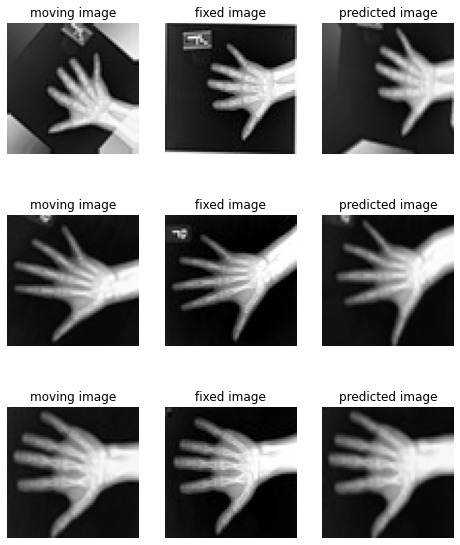

In [14]:
%matplotlib inline
batch_size = 3
plt.subplots(batch_size, 3, figsize=(8, 10))
for b in range(batch_size):
    # moving image
    plt.subplot(batch_size, 3, b * 3 + 1)
    plt.axis('off')
    plt.title("moving image")
    plt.imshow(moving_image[b], cmap="gray")
    # fixed image
    plt.subplot(batch_size, 3, b * 3 + 2)
    plt.axis('off')
    plt.title("fixed image")
    plt.imshow(fixed_image[b], cmap="gray")
    # warped moving
    plt.subplot(batch_size, 3, b * 3 + 3)
    plt.axis('off')
    plt.title("predicted image")
    plt.imshow(pred_image[b], cmap="gray")
plt.axis('off')
plt.show()